In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS

5660
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
for _ in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# CL   - classical (simulations)
# QuCF - framework used for quantum computations
# LCHS - Linear Combination of Hamiltonian Simulations
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)
def calc_kvN_classical():
    nt = 14
    Nt = 1<<nt
    t = np.linspace(0, t_max_, Nt)
    psi_cl = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx_, psi_init_, H_UW_)

    return psi_cl, t

# --- two attractors ---
F_ = lambda x:  - np.sin(x) * (np.sin(x)**2 - 0.25) 
t_max_, x_max = 4.0, 1
# ----------------------------------------

nx_ = 7
Nx_ = 1 << nx_
x_ = np.linspace(-x_max, x_max, Nx_)  

# --- Hermitian and anti-Hermitian parts of i*H ---
print("\n--- UPWINDING DIFFERENCE SCHEME ---")
H_UW_, Aa_, Ah_, _, _ = kvn.construct_UW_matrix_1D(x_, F_, flag_asin = False)
print()
print("Aa.Ah - Ah.Aa: {:20.3e}".format(np.max(Ah_.dot(Aa_) - Aa_.dot(Ah_))))

_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

psi_init_ = np.ones(Nx_) * 2**(-nx_/2.)
psi_cl_, t_cl_ = calc_kvN_classical()


--- UPWINDING DIFFERENCE SCHEME ---

Aa.Ah - Ah.Aa: 0.000e+00+2.377e+01j
Matrix Ah:	 nonsparsity, coefnorm: 3, 8.622e+01
Matrix Aa:	 nonsparsity, coefnorm: 2, 3.319e+01


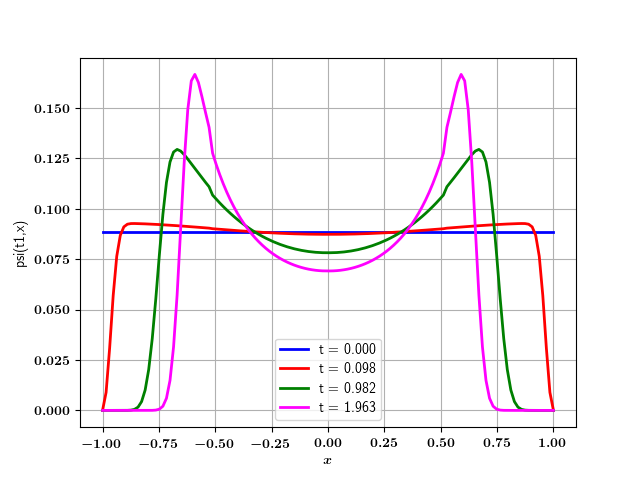

In [5]:
# ------------------------------------------------------------------
# --- Plotting the classical result at various time moments ---
# ------------------------------------------------------------------
def plot_cl_moments(t_moments):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for it in range(len(t_moments)):
        id_t = t_moments[it]
        ax.plot(
            x_, psi_cl_[id_t, :].real, 
            color=colors_[it], linewidth = 2, linestyle='-',  
            label = "t = {:0.3f}".format(t_cl_[id_t])
        )
    plt.xlabel('$x$')
    plt.ylabel("psi(t1,x)")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# -------------------------------------------------------------------------
plot_cl_moments(t_moments = [0, 400, 4020, 8040])

In [37]:
# -----------------------------------------------
# --- LCHS parameters ----
# -----------------------------------------------
def find_norm_time_intervals():
    norm_qsvt_a = 0.35
    norm_qsvt_k = 0.90

    _, _, _ = kvn.compute_norm_matrices_LCHS(
        Aa_, Ah_, k_max_, dk_, 
        t_step = tau_,
        factor_global_a    = 1. / norm_qsvt_a,
        factor_global_kmax = 1. / norm_qsvt_k,
        factor_global_k    = 1. / norm_qsvt_k,
    )
    return 
# --------------------------------------------------

# nk_init_, n_dk_ = 5, 0 
nk_init_, n_dk_ = 7, 0    # for LCHS with circuit
# nk_init_, n_dk_ = 7, 2    # to reduce the oscillations near boundary


# t_LCHS_, Nt_ = 0.10, 1
# t_LCHS_, Nt_ = 1.0, 10   # for LCHS with circuit
t_LCHS_, Nt_ = 2.0, 20     # for LCHS with circuit
# t_LCHS_, Nt_ = 1.0, 100

# --- Time grid ---
tau_ = t_LCHS_ / Nt_
print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t_LCHS_, tau_, Nt_))

# --- Fourier k-grid ---
nk_ = nk_init_ + n_dk_
Nk_ = 1 << nk_
dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)
dk_comp = LCHS.get_dk(norm_Ah_, norm_Aa_, t_LCHS_, n_dk_)
k_max_ = 0.5 * dk_ * (Nk_ - 1)
k_grid_ = np.linspace(-k_max_, k_max_, Nk_)

# --- Print parameters ---
print("kmax, nk:\t {:0.12f}, {:d}".format(k_max_, nk_))
print("dk:\t\t {:0.3e}".format(dk_))
print("dk_comp:\t {:0.3e}\n".format(dk_comp))

# --- Parameters for the BE of the weights ---
print("//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)
print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))

print("\n--- Matrix norms ---")
find_norm_time_intervals()

# --- interpolate classical simulation ---
y_cl_interp_ = np.zeros(Nx_)
for ix in range(Nx_):
    y_cl_interp_[ix] = np.interp(t_LCHS_, t_cl_, psi_cl_[:,ix].real) 

# --- Strings to save data latter ---
str_save_t_ = "t{:0.3f}".format(tau_)
str_save_pyLCHS_ = "kmax{:d}_dk{:d}".format(int(k_max_), int(1000*dk_))

name_t_ = None
if t_LCHS_ == 0.10:  
    name_t_ = "dt01"
if t_LCHS_ == 1.0:  
    name_t_ = "dt1"
if t_LCHS_ == 2.0:  
    name_t_ = "t2"

del dk_comp

t, tau, N_steps: 2.000e+00, 1.000e-01, 20
kmax, nk:	 40.967741935484, 7
dk:		 6.452e-01
dk_comp:	 6.452e-01

//--- Angles for the weight-oracle ---
nk 	7
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.007874015748e+00

--- Matrix norms ---
Matrix Ba:	 nonsparsity, coefnorm: 2, 3.319e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 3.532e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 5.562e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

--- Time steps ---
dt_a, dt_kmax, dt_k: 4.741402097111e+00, 3.924537573137e+02, 6.180374130925e+00


In [26]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
mix.reload_module(LCHS)

psi_py_ = kvn.LCHS_computation(
    k_grid_, tau_,
    1j * H_UW_, 
    psi_init_, Nt_, 
    flag_trotterization = True,
    flag_print = False
)
print("Done.")

print("\n--- Maximum abs. difference between LCHS-PY and classical simulations error ---")
max_abs_err = np.max(np.abs(y_cl_interp_ - psi_py_))
print("max. abs. error: {:0.3e}".format(max_abs_err))

Done.

--- Maximum abs. difference between LCHS-PY and classical simulations error ---
max. abs. error: 8.723e-03


In [39]:
# --------------------------------------------------
# --- Compare classical and LCHS-py simulations  ---
# --------------------------------------------------
mix.reload_module(mix)
def compare_CL_LCHS_PY(flag_save):
    # --- Plotting signals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_cl_interp_,     "-b",  linewidth = 2, label = "ref")
    ax.plot(x_, psi_py_.real, "--r", linewidth = 2, label = "LCHS")
    plt.xlabel('$x$')
    plt.ylabel("y")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting errors ---
    abs_err = y_cl_interp_ - psi_py_.real

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, abs_err, "-b",  linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("ref - LCHS")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_CL_t{:d}.dat".format(int(t_LCHS_)), 
            x_, y_cl_interp_
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_PY_LCHS_t{:d}_{:s}_{:s}.dat".format(int(t_LCHS_), str_save_t_, str_save_pyLCHS_), 
            x_, psi_py_.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_PY_LCHS_ERR_t{:d}_{:s}_{:s}.dat".format(int(t_LCHS_), str_save_t_, str_save_pyLCHS_), 
            x_, np.log10(np.abs(abs_err))
        )

    return
# -------------------------------------------------------------------
compare_CL_LCHS_PY(flag_save = False)

write data to a file: ./jupyter-notebooks/NL/results//KVN_CL_t2.dat



Reading the file ../QuCF/simulations/LCHS/KvN/t2//kvn_OUTPUT.hdf5...
Name of the simulation is kvn
Simulation has been performed  07-12-2024 08:57:45
A-max: 1.626406949907e-01
success prob: 8.385756925054e-01
N-gates: 216035175

 len: 128

max-err: 8.711e-03


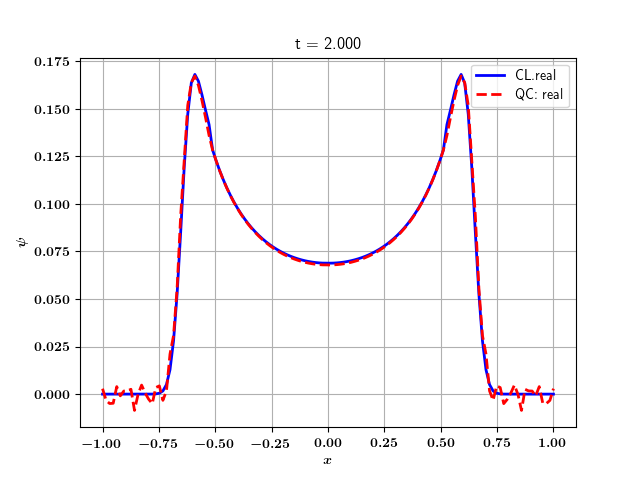

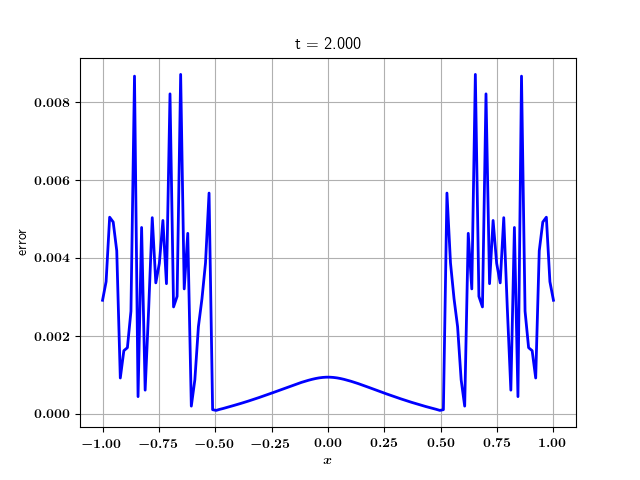

write data to a file: ./jupyter-notebooks/NL/results//KvN_QuCF_t2.dat
write data to a file: ./jupyter-notebooks/NL/results//KvN_QuCF_ERR_t2.dat


In [40]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
def read_qc_data(path_qc, name_qc = "kvn"):
    print()  

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qc
    om.pname_ = name_qc
    om.open()
    
    # --- get the result ---
    Ngates = om.dd_["N-gates"]
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    
    print("A-max: {:0.12e}".format(np.max(np.abs(qc_state))))
    print("success prob: {:0.12e}".format(  np.sum(np.abs(qc_state)**2)  ))
    print("N-gates: {:d}".format(Ngates))
  
    # --- take into account that weights are amplified:
    rr_w = None # these coefficients are computed in calc-weights.ipynb
    if int(k_max_) == 40 and nk_ == 7: 
        rr_w = 5.056431725491e+00

    # --- Renormalization of the quantum state ---
    qc_state *= 2**(nk_) * (dk_ / np.pi) / rr_w**2
    return qc_state
# ------------------------------------------------------------------------------
def compare_ref_qu(flag_save):

    # --- Choose the reference signal ---
    y_ref_ch, flag_imag, str_ref = np.array(y_cl_interp_), False, "CL"
    # y_ref_ch, flag_imag, str_ref = np.array(psi_py_), True, "LCHS-py"

    # --- QuCF signal ---
    psi_qc = read_qc_data(
        "../QuCF/simulations/LCHS/KvN/{:s}/".format(name_t_), 
        "kvn"
    )

    print("\n len: {:d}\n".format(len(psi_qc)))

    # --- Compute the absolute error ---
    err_res = np.abs(y_ref_ch - psi_qc)
    max_abs_err = np.max(np.abs(err_res))
    print("max-err: {:0.3e}".format(max_abs_err))

    # --- Compare the quantum state and the reference simulation ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    ax.plot(x_, y_ref_ch.real, "-", color = "blue",   linewidth = 2, label = "{:s}.real".format(str_ref))
    ax.plot(x_, psi_qc.real,  "--", color = "red",    linewidth = 2, label = "QC: real")
    if flag_imag:
        ax.plot(x_, y_ref_ch.imag, "-", color = "green",  linewidth = 2, label = "{:s}.imag".format(str_ref))
        ax.plot(x_, psi_qc.imag,  "--", color = "orange", linewidth = 2, label = "QC: imag")

    plt.xlabel('$x$')
    plt.ylabel("$\psi$")
    ax.legend()
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()

    # --- Absolute error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, err_res, "-b", linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("error")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()


    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/KvN_QuCF_t{:d}.dat".format(int(t_LCHS_)),  
            x_, psi_qc.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KvN_QuCF_ERR_t{:d}.dat".format(int(t_LCHS_)),  
            x_, np.log10(err_res)
        )
    return
# ------------------------------------------------------------------------------
compare_ref_qu(flag_save = True)